<a href="https://colab.research.google.com/github/srinivasanprashant/skiers-vs-snowboarders-deep-learning/blob/master/skiing_vs_snowboarding_CNN_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Skiing vs. Snowboarding using FastAI and Resnet-34 CNN

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Here we will build a simple image classifier from scratch using a very small training set of images of people skiing and snowboarding, and see if we can achieve reasonable results.  At some point we may then augment the image set and re-run to see if that results in further improvments to the model's accuracy.

First lets start off with some code to allow my folders containing training/test images from google drive to load and some code to ensure that any edits to libraries are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size*, and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use images of skiing and snowboarding from google. There are approximately 50 images each. Our model will need to learn to differentiate between these two categories. A simple random guessing strategy would allow us to get a 50% accuracy over a large dataset. However, with a small test set (say 20 images), that accuracy would be all over the place. With a deep learning model, I would like to see an error rate below 15% for several iterations of the tests.  Let's see how accurate we can be using deep learning! 

In [0]:
# Adding the correct path to base_dir to access the images on Google Drive
path = Path(base_dir + "Snowsports")
path

PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports')

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/models')]

In [0]:
# path_img = path/'Ski'
# print(path_img)

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames1 = get_image_files(path/"train/Ski")
fnames1[:10]

[PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/10559-a-woman-snow-skiing-pv.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/10571-a-woman-snow-skiing-pv.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/500_F_183037421_HEhrJoY5e3EZHAWgPg4heYPQGccECJ6K.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/10569-a-woman-snow-skiing-pv.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/competition-clipart-Sports5.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/IMG_3638.JPG'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/skier_at_mountain_peak_187645.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/16168304-funny-winter-scene-man-jumping-cross-country-skiing.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Ski/8753354_orig.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/S

In [0]:
fnames2 = get_image_files(path/"train/Snowboard")
fnames2[:10]

[PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/depositphotos_244250594-stock-photo-young-guy-snowboarder-is-riding.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/photography-snow-board-extreme-sport-10-2015-file-photo-a-snowboarder-goes-over.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/Snowboarding-snow-20185680-670-524.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/RS-Snowboarder-1920.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/180419150453004_Andre+Cintra_0.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/48056-kelly-clark-getty-facebook.800w.tn.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/jamie-anderson-snowboard.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/Snowsports/train/Snowboard/snowboard-legend-craig-kelly-in-action-in-1989.jpg'),
 Posi

In [0]:
# np.random.seed(2)
# pat = r'/([^/]+)_\d+.jpg$'
# print(pat)

In [0]:
# data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs//4).normalize(imagenet_stats)
data = ImageDataBunch.from_folder(path, train='.', valid_pct = 0.25, ds_tfms=get_transforms(), 
                                  size=450, bs=25).normalize(imagenet_stats)

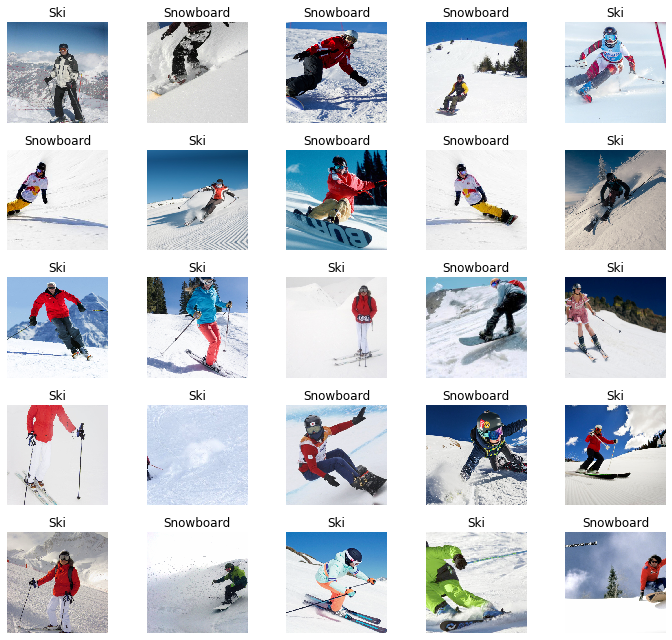

In [0]:
data.show_batch(rows=5, figsize=(10,9))

In [0]:
print(data.classes)
len(data.classes),data.c

['Ski', 'Snowboard']


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 22.1MB/s]


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.139572,2.012008,0.500000,00:13
1,1.028599,0.807498,0.375000,00:06
2,0.798039,0.307804,0.166667,00:05
3,0.647066,0.180893,0.083333,00:04


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

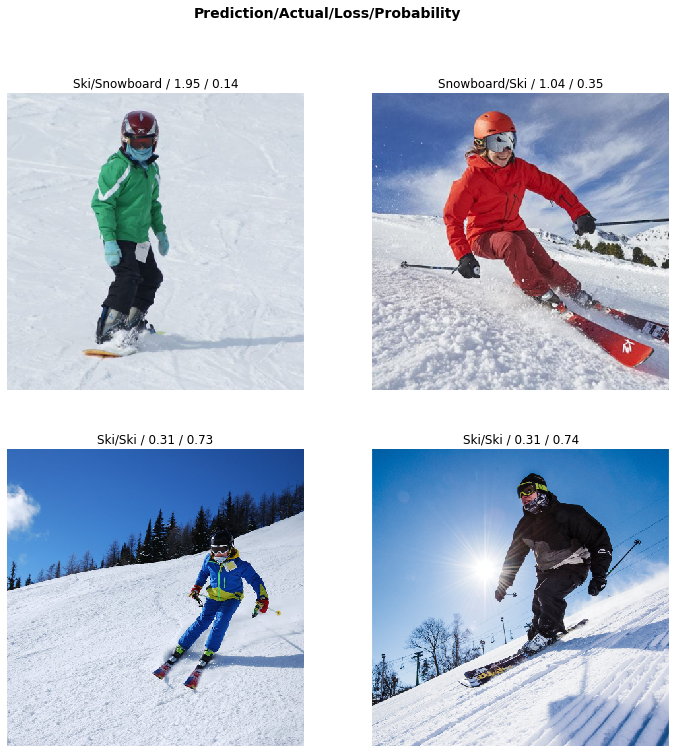

In [0]:
interp.plot_top_losses(4)

In [0]:
doc(interp.plot_top_losses)

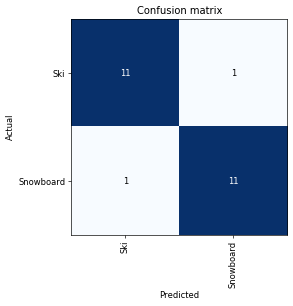

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [0]:
interp.most_confused(min_val=1)

[('Ski', 'Snowboard', 1), ('Snowboard', 'Ski', 1)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.228246,0.344072,0.125000,00:05
1,0.186751,1.355154,0.250000,00:04
2,0.187245,1.015525,0.250000,00:04
3,0.169142,0.724906,0.250000,00:05


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

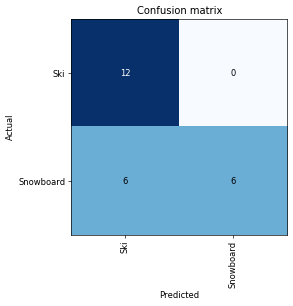

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

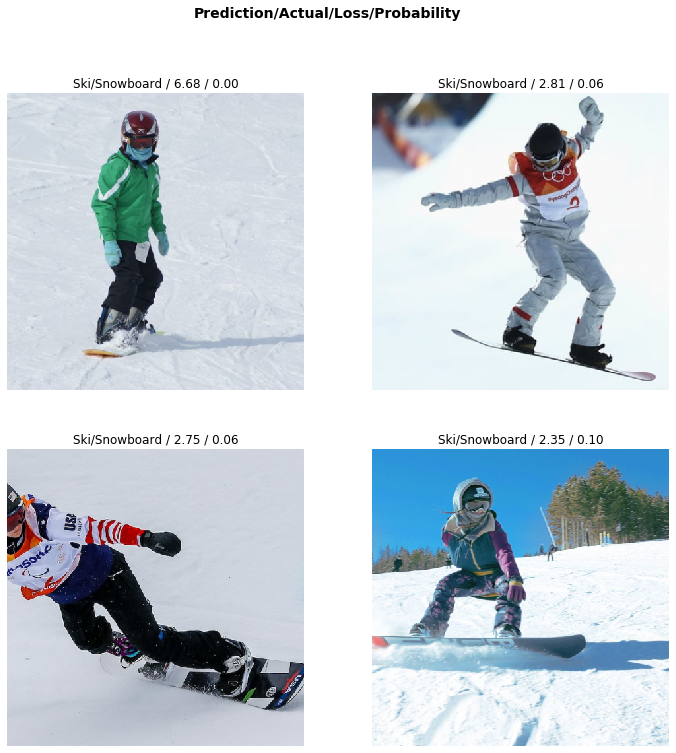

In [0]:
interp.plot_top_losses(4)

In [0]:
interp.most_confused(min_val=2)

[('Snowboard', 'Ski', 6)]

In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


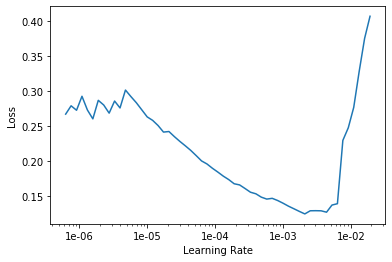

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.260644,0.156304,0.041667,00:05
1,0.223245,0.151304,0.041667,00:04
2,0.202619,0.203590,0.083333,00:05
3,0.190574,0.183365,0.083333,00:04


That's a fairly accurate model given the small number of images for the training set and the fact that almost all images are not sized right so part of the skier or boarder might be cropped. Future work will involve cleaning up the training images and looking into the transforms that generate augmentations to see if we need to limit the images from being flipped or rotated beyond a certain point to help model accuracy.




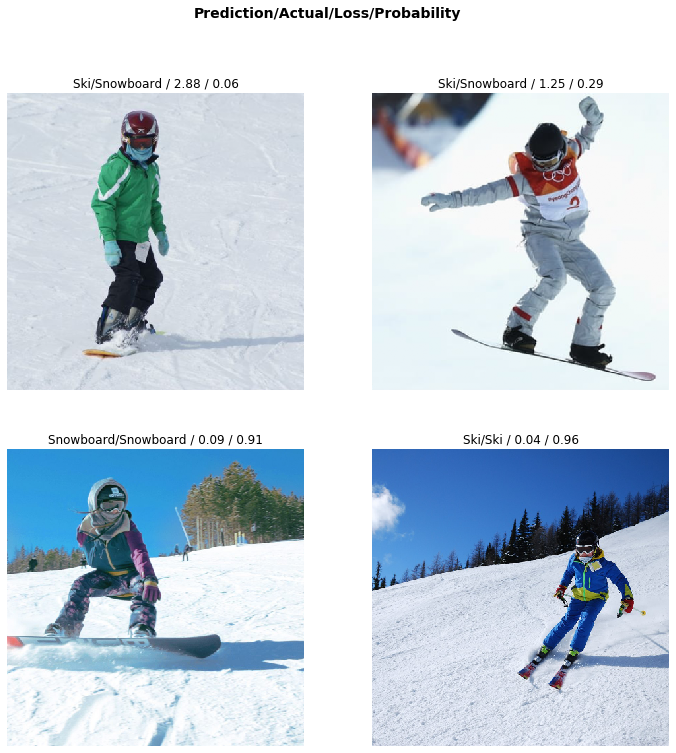

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4)

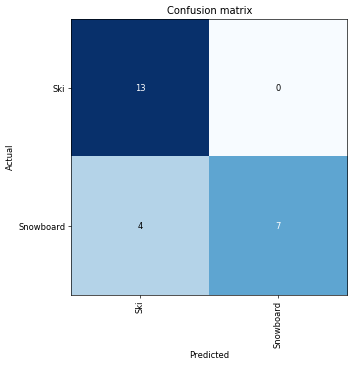

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct = 0.2, ds_tfms=get_transforms(), size=224, bs=15).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 30.3MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


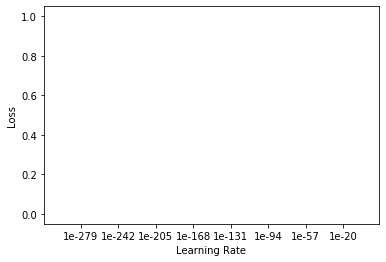

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.008868,1.843259,0.375000,00:04
1,0.004775,1.861624,0.375000,00:04
2,0.003123,2.029948,0.375000,00:04
3,0.103934,2.331372,0.375000,00:03
4,0.081469,2.625140,0.375000,00:03


In [0]:
learn.save('stage-1-50')

Error rates are pretty high.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.292930,2.844279,0.375000,00:03
1,0.246754,2.720704,0.375000,00:04
2,0.263788,2.683602,0.375000,00:03


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[]